In [1]:
# In this notebook, we will evaluate the results of the HIT dataset training runs


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import logging
import pickle

logging.basicConfig(level=logging.INFO)

from scipy.spatial.distance import directed_hausdorff

from src.interface_representation.interface_types import InterfaceType
from src.eval_utils import read_loss_curve_from_file, load_dataset, load_model, run_inference, get_phi_sharp, dice_coefficient, get_phi_sharp_pred_and_gt, hausdorff_distance

#base_output_dir = pathlib.Path('/Volumes/My Passport for Mac/Multiphase-ae/lassen_output')  # TODO
base_output_dir = pathlib.Path('.').resolve().parent.parent / 'output' / 'lassen'
files = list(base_output_dir.glob('interfacial_ae_v35_*'))  # TODO

print(len(files))


24


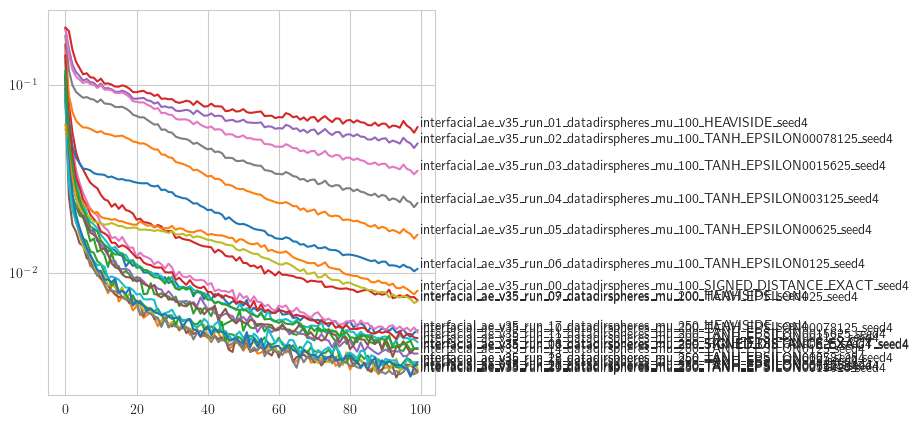

In [3]:

# Compare all the loss curves on one axis


name_to_loss = {}
completed_files = []

for f in files:
    try:
        name_to_loss[f] = read_loss_curve_from_file(f)
        completed_files.append(f)
    except FileNotFoundError:
        print(f'File {f} not found')
        pass


files = list(completed_files)

fig, ax = plt.subplots(figsize=(5, 5))
loss_component = 'Total'
for f, loss in name_to_loss.items():
    ax.plot(loss[loss_component], label=f.name)

    # Annotate name on the end of the curve
    ax.text(len(loss[loss_component]), loss[loss_component][-1], f.name)
    
#ax.legend()
ax.set_yscale('log')
plt.show()



In [4]:
# Functions to group the data by interface type and epsilon

def extract_interface_type(outdir):

    final_part = '_'.join(outdir.stem.split('_')[8:-1])

    str_to_type = {
        'TANH_EPSILON00078125': InterfaceType.TANH_EPSILON,
        'TANH_EPSILON0015625': InterfaceType.TANH_EPSILON,
        'TANH_EPSILON003125': InterfaceType.TANH_EPSILON,
        'TANH_EPSILON00625': InterfaceType.TANH_EPSILON,
        'TANH_EPSILON0125': InterfaceType.TANH_EPSILON,
        'TANH_EPSILON025': InterfaceType.TANH_EPSILON,
        'HEAVISIDE': InterfaceType.HEAVISIDE,
        'SIGNED_DISTANCE_EXACT': InterfaceType.SIGNED_DISTANCE_EXACT,
        'SIGNED_DISTANCE_APPROXIMATE': InterfaceType.SIGNED_DISTANCE_APPROXIMATE,
    }

    return str_to_type[final_part]

def extract_epsilon(outdir):
    final_part = '_'.join(outdir.stem.split('_')[8:-1])

    str_to_epsilon = {
        'TANH_EPSILON00078125': 0.0078125,
        'TANH_EPSILON0015625': 0.015625,
        'TANH_EPSILON003125': 0.03125,
        'TANH_EPSILON00625': 0.0625,
        'TANH_EPSILON0125': 0.125,
        'TANH_EPSILON025': 0.25,
        'HEAVISIDE': None,
        'SIGNED_DISTANCE_EXACT': None,
        'SIGNED_DISTANCE_APPROXIMATE': None,
    }

    return str_to_epsilon[final_part]


def get_model_path(outdir):
    return outdir / 'model-100.pt'


def extract_mu(outdir):
    mu_part = outdir.stem.split('_')[7]

    if mu_part == '100':
        return 1.00
    elif mu_part == '200':
        return 2.00
    elif mu_part == '250':
        return 2.50
    else:
        raise ValueError

def get_dataset_path(mu, interfacetype, epsilon):
    if interfacetype == InterfaceType.TANH_EPSILON:
        return pathlib.Path(f'/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/mu_spheres/spheres_mu_{mu:.2f}/TANH_EPSILON{epsilon}')
    elif interfacetype == InterfaceType.HEAVISIDE:
        return pathlib.Path(f'/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/mu_spheres/spheres_mu_{mu:.2f}/HEAVISIDE')
    elif interfacetype == InterfaceType.SIGNED_DISTANCE_EXACT:
        return pathlib.Path(f'/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/mu_spheres/spheres_mu_{mu:.2f}/SIGNED_DISTANCE_EXACT')
    elif interfacetype == InterfaceType.SIGNED_DISTANCE_APPROXIMATE:
        return pathlib.Path(f'/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/mu_spheres/spheres_mu_{mu:.2f}/SIGNED_DISTANCE_APPROXIMATE')
    else:
        raise ValueError('Unknown interface type')


In [5]:
outdir_to_params = {}

for outdir in files:
    interfacetype = extract_interface_type(outdir)
    mu = extract_mu(outdir)
    epsilon = extract_epsilon(outdir)
    model_path = get_model_path(outdir)
    dataset_path = get_dataset_path(mu, interfacetype, epsilon)

    assert model_path.exists()
    assert dataset_path.exists(), f'{dataset_path} does not exist'

    params = {
        'mu': mu,
        'interface_type': interfacetype,
        'epsilon': epsilon,
        'model_path': model_path,
        'dataset_path': dataset_path
    }

    outdir_to_params[outdir] = params

print(outdir_to_params)

    
# Sort

outdir_to_params = {key: outdir_to_params[key] for key in sorted(outdir_to_params.keys(), key=lambda x: x.stem)}

print(outdir_to_params)

{PosixPath('/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/output/lassen/interfacial_ae_v35_run_17_datadirspheres_mu_250_HEAVISIDE_seed4'): {'mu': 2.5, 'interface_type': <InterfaceType.HEAVISIDE: 4>, 'epsilon': None, 'model_path': PosixPath('/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/output/lassen/interfacial_ae_v35_run_17_datadirspheres_mu_250_HEAVISIDE_seed4/model-100.pt'), 'dataset_path': PosixPath('/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/mu_spheres/spheres_mu_2.50/HEAVISIDE')}, PosixPath('/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/output/lassen/interfacial_ae_v35_run_20_datadirspheres_mu_250_TANH_EPSILON003125_seed4'): {'mu': 2.5, 'interface_type': <InterfaceType.TANH_EPSILON: 1>, 'epsilon': 0.03125, 'model_path': PosixPath('/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/output/lassen/interfacial_ae_v35_run_20_datadirspheres_mu_250

In [6]:
# Run inference for all

for outdir, params in outdir_to_params.items():
    print(outdir)
    outfile = outdir / 'inference.npz'

    if outfile.exists():
        continue
    
    dataset = load_dataset(params['dataset_path'], max_num_samples=25_000, split='val')
    model = load_model(params['model_path'])
    gts, preds = run_inference(dataset, model, N=500)  # 500*9s = 4500s = 1.25 hours
    
    # Save outdir, preds, params, gt to disk, ready to be reloaded at evaluation time! 
    np.savez_compressed(outfile, gts=gts, preds=preds, **params)

/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/output/lassen/interfacial_ae_v35_run_00_datadirspheres_mu_100_SIGNED_DISTANCE_EXACT_seed4
/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/output/lassen/interfacial_ae_v35_run_01_datadirspheres_mu_100_HEAVISIDE_seed4
/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/output/lassen/interfacial_ae_v35_run_02_datadirspheres_mu_100_TANH_EPSILON00078125_seed4
/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/output/lassen/interfacial_ae_v35_run_03_datadirspheres_mu_100_TANH_EPSILON0015625_seed4
/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/output/lassen/interfacial_ae_v35_run_04_datadirspheres_mu_100_TANH_EPSILON003125_seed4
/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/output/lassen/interfacial_ae_v35_run_05_datadirspheres_mu_100_TANH_EPSILON00625_seed4
/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_

In [7]:

# Go over each file, and load predictions, compute metrics from each volume

def vol_error(gt, pred):
    return np.abs(np.sum(gt) - np.sum(pred))

def rel_vol_error(gt, pred):
    return np.abs(np.sum(gt) - np.sum(pred)) / np.sum(gt)


outdir_to_metrics = {}

for outdir, params in outdir_to_params.items():
    print(outdir)
    outfile = outdir / 'inference.npz'
    data = np.load(outfile)

    gts = data['gts']
    preds = data['preds']

    # Convert to sharp interface
    interfacetype = params['interface_type']

    dices = []
    vol_errors = []
    rel_vol_errors = []
    hds = []

    for gt, pred in zip(gts, preds):
        gt = get_phi_sharp(gt, interfacetype)
        pred = get_phi_sharp(pred, interfacetype)

        dice = dice_coefficient(gt, pred)
        vol_err = vol_error(gt, pred)
        rel_vol_err = rel_vol_error(gt, pred)
        hd = hausdorff_distance(gt, pred, level=0.5)

        dices.append(dice)
        vol_errors.append(vol_err)
        rel_vol_errors.append(rel_vol_err)
        hds.append(hd)

    outdir_to_metrics[outdir] = {
        'Dice': dices,
        'VolError': vol_errors,
        'RelVolError': rel_vol_errors,
        'Hausdorff': hds,
        'gts': gts,
        'preds': preds
    }


/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/output/lassen/interfacial_ae_v35_run_00_datadirspheres_mu_100_SIGNED_DISTANCE_EXACT_seed4
/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/output/lassen/interfacial_ae_v35_run_01_datadirspheres_mu_100_HEAVISIDE_seed4
/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/output/lassen/interfacial_ae_v35_run_02_datadirspheres_mu_100_TANH_EPSILON00078125_seed4
/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/output/lassen/interfacial_ae_v35_run_03_datadirspheres_mu_100_TANH_EPSILON0015625_seed4
/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/output/lassen/interfacial_ae_v35_run_04_datadirspheres_mu_100_TANH_EPSILON003125_seed4
/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/output/lassen/interfacial_ae_v35_run_05_datadirspheres_mu_100_TANH_EPSILON00625_seed4
/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_

KeyboardInterrupt: 

In [ ]:
import pandas as pd

# Store all evaluation results in this dataframe to use for plotting from

data = []

for outdir, params in outdir_to_params.items():
    metrics = outdir_to_metrics[outdir]
    for i, (dice, vol_error, hausdorff) in enumerate(zip(metrics['Dice'], metrics['VolError'], metrics['Hausdorff'])):
        data.append({
            'outdir': str(outdir),
            'test_sample_index': i,
            'mu': params['mu'],
            'interface_type': params['interface_type'].name,
            'epsilon': params['epsilon'],
            'dice': dice,
            'vol_error': vol_error,
            'rel_vol_error': metrics['RelVolError'][i],
            'hausdorff': hausdorff
        })

df = pd.DataFrame(data)
df.to_csv('output/evaluation_results_v35.csv', index=False)
df.head()

# Store outdir_to_metrics to file
import pickle

with open('output/comparison_synthetic_outdir_to_metrics.pkl', 'wb') as f:
    pickle.dump(outdir_to_metrics, f)


Dice: 0.9793199882249043, Vol frac: 0.05104827880859375, Sigma: 19.93243408203125, Num components: 4


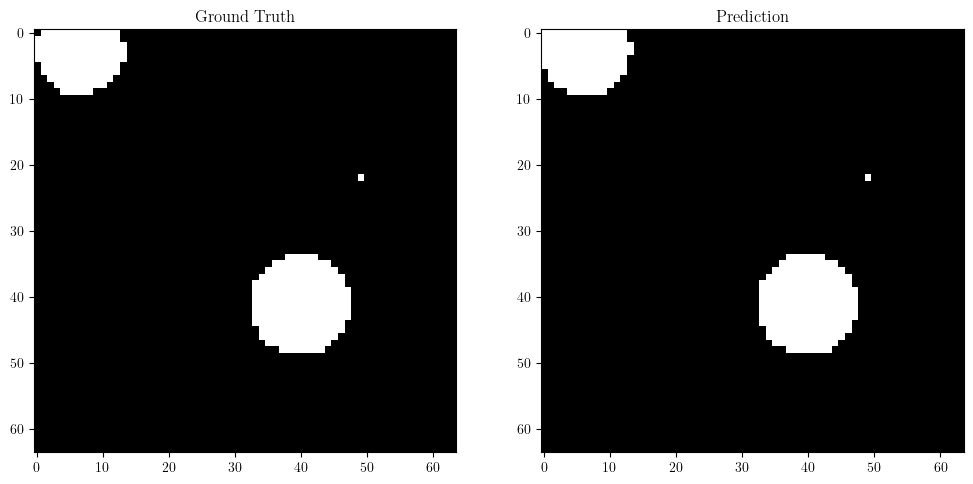

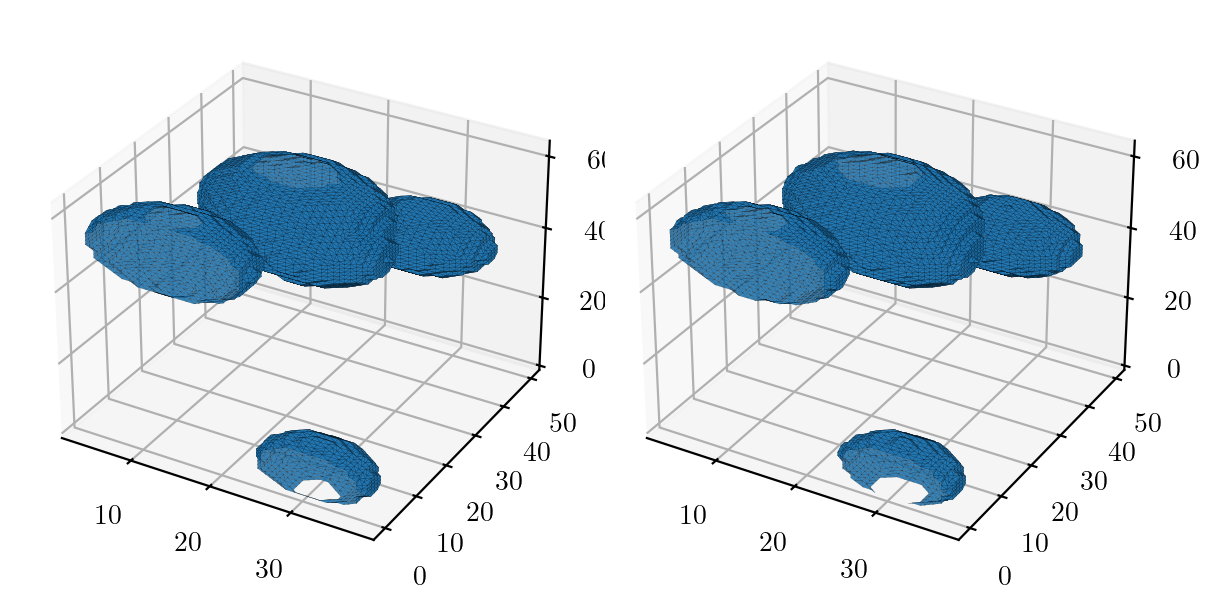

In [11]:


from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import skimage
from scipy import ndimage
import matplotlib

matplotlib.rc_file_defaults()

def compute_volume_fraction(phi):
    return np.sum(phi) / phi.size


def compute_surface_area_density(phi):
    # Assume phi represents a volume fraction
    dx = 1 / phi.shape[-1]
    grad_phi = np.gradient(phi, dx)  # List of (64, 64, 64) arrays
    abs_grad_phi = np.sqrt(np.sum([g**2 for g in grad_phi], axis=0))
    surface_area = np.sum(abs_grad_phi)
    volume = np.sum(phi)
    return surface_area / volume

def compute_num_components(phi):
    labeled_arr, num_labels = ndimage.label(phi)
    return num_labels

def visualize_gt_pred(interface_type, mu, epsilon, sample_index):
    for outdir, params in outdir_to_params.items():
        if params['interface_type'] == interface_type and params['mu'] == mu and params['epsilon'] == epsilon:

            data = np.load(outdir / 'inference.npz')
            gts = data['gts']
            preds = data['preds']

            gt = gts[sample_index]
            pred = preds[sample_index]

            gt = get_phi_sharp(gt, interface_type)
            pred = get_phi_sharp(pred, interface_type)

            dice = dice_coefficient(gt, pred)
            vol_frac = compute_volume_fraction(gt)
            sigma = compute_surface_area_density(gt)
            num_components = compute_num_components(gt)

            print(f'Dice: {dice}, Vol frac: {vol_frac}, Sigma: {sigma}, Num components: {num_components}')

            fig, axs = plt.subplots(1, 2, figsize=(12, 6))
            axs[0].imshow(gt[gt.shape[0] // 2], cmap='gray')
            axs[0].set_title('Ground Truth')
            axs[1].imshow(pred[pred.shape[0] // 2], cmap='gray')
            axs[1].set_title('Prediction')
            plt.show()



            fig = plt.figure(figsize=(6, 6), dpi=200)
            ax = fig.add_subplot(121, projection="3d")
            verts, faces, normals, values = skimage.measure.marching_cubes(
                gt, 0.5, spacing=(1, 1, 1), allow_degenerate=False, method='lewiner'
            )
            mesh = Poly3DCollection(verts[faces])
            mesh.set_edgecolor("k")
            mesh.set_linewidth(0.05)
            mesh.set_alpha(0.9)
            ax.add_collection3d(mesh)

            ax = fig.add_subplot(122, projection="3d")
            verts, faces, normals, values = skimage.measure.marching_cubes(
                pred, 0.5, spacing=(1, 1, 1), allow_degenerate=False, method='lewiner'
            )
            mesh = Poly3DCollection(verts[faces])
            mesh.set_edgecolor("k")
            mesh.set_linewidth(0.05)
            mesh.set_alpha(0.9)
            ax.add_collection3d(mesh)

            plt.tight_layout()
            break

# Example usage
visualize_gt_pred(InterfaceType.TANH_EPSILON, 2.0, 1/32, 0)


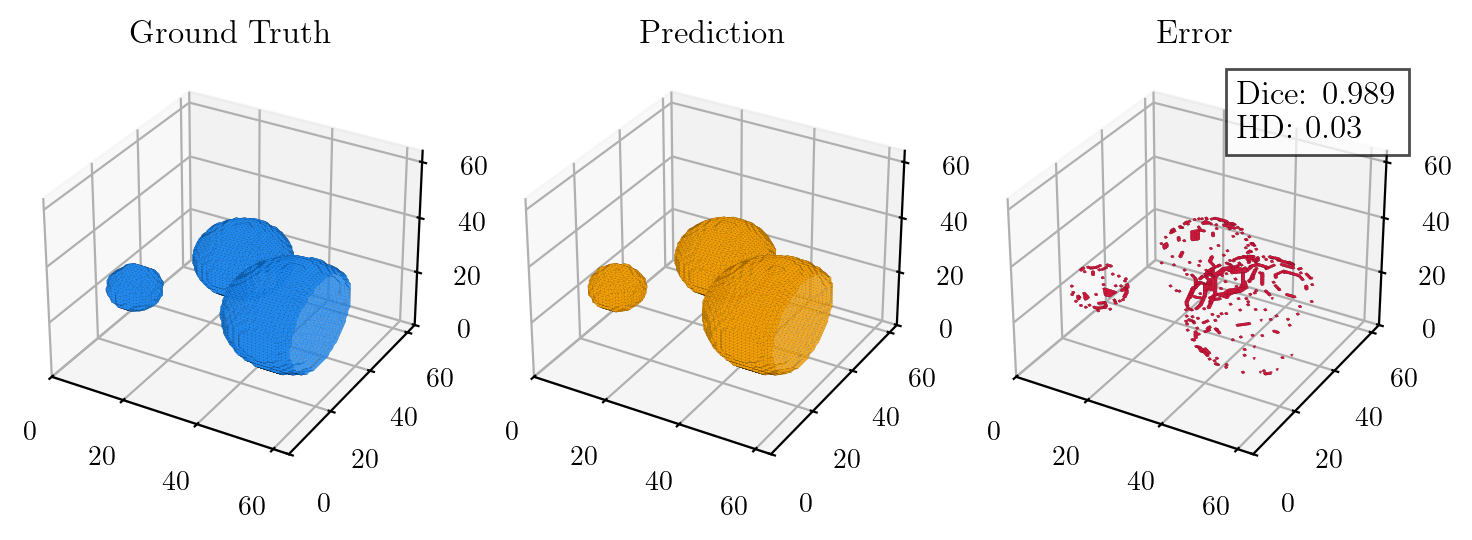

In [37]:
def visualize_gt_pred(interface_type, mu, epsilon, sample_index, outpath=None):
    for outdir, params in outdir_to_params.items():
        if params['interface_type'] == interface_type and params['mu'] == mu and params['epsilon'] == epsilon:

            data = np.load(outdir / 'inference.npz')
            gts = data['gts']
            preds = data['preds']

            gt = gts[sample_index]
            pred = preds[sample_index]

            gt = get_phi_sharp(gt, interface_type)
            pred = get_phi_sharp(pred, interface_type)

            dice = dice_coefficient(gt, pred)
            hd = hausdorff_distance(gt, pred, level=0.5) / 64.0

            # 3D Visualization GT, Pred, Error
            fig = plt.figure(figsize=(7.5, 2.5), dpi=200)
            # GT
            ax1 = fig.add_subplot(131, projection="3d")
            verts, faces, normals, values = skimage.measure.marching_cubes(
                gt, 0.5, spacing=(1, 1, 1), allow_degenerate=False, method='lewiner'
            )
            mesh = Poly3DCollection(verts[faces], alpha=0.9, facecolor='dodgerblue')
            mesh.set_edgecolor("k")
            mesh.set_edgecolor((0,0,0,0.3))
            mesh.set_linewidth(0.02)
            ax1.add_collection3d(mesh)
            ax1.set_xlim(0, gt.shape[0])
            ax1.set_ylim(0, gt.shape[1])
            ax1.set_zlim(0, gt.shape[2])
            ax1.set_title('Ground Truth')
            #ax1.axis('off')

            # Pred
            ax2 = fig.add_subplot(132, projection="3d")
            verts, faces, normals, values = skimage.measure.marching_cubes(
                pred, 0.5, spacing=(1, 1, 1), allow_degenerate=False, method='lewiner'
            )
            mesh = Poly3DCollection(verts[faces], alpha=0.9, facecolor='orange')
            mesh.set_edgecolor("k")
            mesh.set_edgecolor((0,0,0,0.3))
            mesh.set_linewidth(0.02)
            ax2.add_collection3d(mesh)
            ax2.set_xlim(0, pred.shape[0])
            ax2.set_ylim(0, pred.shape[1])
            ax2.set_zlim(0, pred.shape[2])
            ax2.set_title('Prediction')
            #ax2.axis('off')

            # Error (XOR of 0.5-thresholded)
            ax3 = fig.add_subplot(133, projection="3d")
            error = np.logical_xor(gt > 0.5, pred > 0.5)
            if np.any(error):
                verts, faces, normals, values = skimage.measure.marching_cubes(
                    error.astype(np.float32), 0.5, spacing=(1, 1, 1), allow_degenerate=False, method='lewiner'
                )
                mesh = Poly3DCollection(verts[faces], alpha=0.9, facecolor='crimson')
                mesh.set_edgecolor("k")
                mesh.set_edgecolor((0,0,0,0.3))
                mesh.set_linewidth(0.02)
                ax3.add_collection3d(mesh)
            ax3.set_xlim(0, gt.shape[0])
            ax3.set_ylim(0, gt.shape[1])
            ax3.set_zlim(0, gt.shape[2])
            ax3.set_title('Error')
            #ax3.axis('off')
            # Annotate Dice and HD
            ax3.text2D(
                0.6, 0.95,
                f"Dice: {dice:.3f}\nHD: {hd:.2f}",
                transform=ax3.transAxes, fontsize=12,
                va='top', bbox=dict(fc="white", alpha=0.7)
            )

            plt.tight_layout()

            if outpath is not None:
                plt.savefig(outpath)

            plt.show()
            break

visualize_gt_pred(InterfaceType.TANH_EPSILON, 2.0, 1/32, 1)


In [19]:

def find_samples_in_volume_fraction_window(interface_type, mu, epsilon, volume_fraction_min, volume_fraction_max):
    sample_indices = []

    for outdir, params in outdir_to_params.items():
        if params['interface_type'] == interface_type and params['mu'] == mu and params['epsilon'] == epsilon:
            data = np.load(outdir / 'inference.npz')
            gts = data['gts']
            preds = data['preds']

            for i, gt, pred in zip(range(len(gts)), gts, preds):
                gt = get_phi_sharp(gt, interface_type)
                pred = get_phi_sharp(pred, interface_type)
                dice = dice_coefficient(gt, pred)
                vol_frac = compute_volume_fraction(gt)
                if volume_fraction_min <= vol_frac <= volume_fraction_max:
                    sample_indices.append((i, dice))

    return sample_indices


# Example usage
sample_indices = find_samples_in_volume_fraction_window(InterfaceType.TANH_EPSILON, 2.0, 1 / 32, 0.15, 0.20)
print(sample_indices)
# Visualise a good and bad sample with same volume fraction



[(8, np.float64(0.9839573262877673)), (11, np.float64(0.9844938412014989)), (14, np.float64(0.9559680552557738)), (16, np.float64(0.9774970486935144)), (21, np.float64(0.9676794850842898)), (24, np.float64(0.9656939988229264)), (42, np.float64(0.9820007555539307)), (51, np.float64(0.9789114031194195)), (66, np.float64(0.9900452841973766)), (81, np.float64(0.9838053053302145)), (83, np.float64(0.9564660125519314)), (86, np.float64(0.9728494413626064)), (87, np.float64(0.9818644811315708)), (94, np.float64(0.9877679981945385)), (95, np.float64(0.9803687791641827)), (99, np.float64(0.985781990521327)), (100, np.float64(0.9867800275211323)), (104, np.float64(0.9677810836204197)), (107, np.float64(0.9876835440601966)), (110, np.float64(0.9753207073564661)), (111, np.float64(0.9730075834884047)), (112, np.float64(0.9653042617229243)), (121, np.float64(0.9600206234290748)), (124, np.float64(0.9491238396166992)), (128, np.float64(0.9943483001040113)), (133, np.float64(0.9744788235147869)), (14

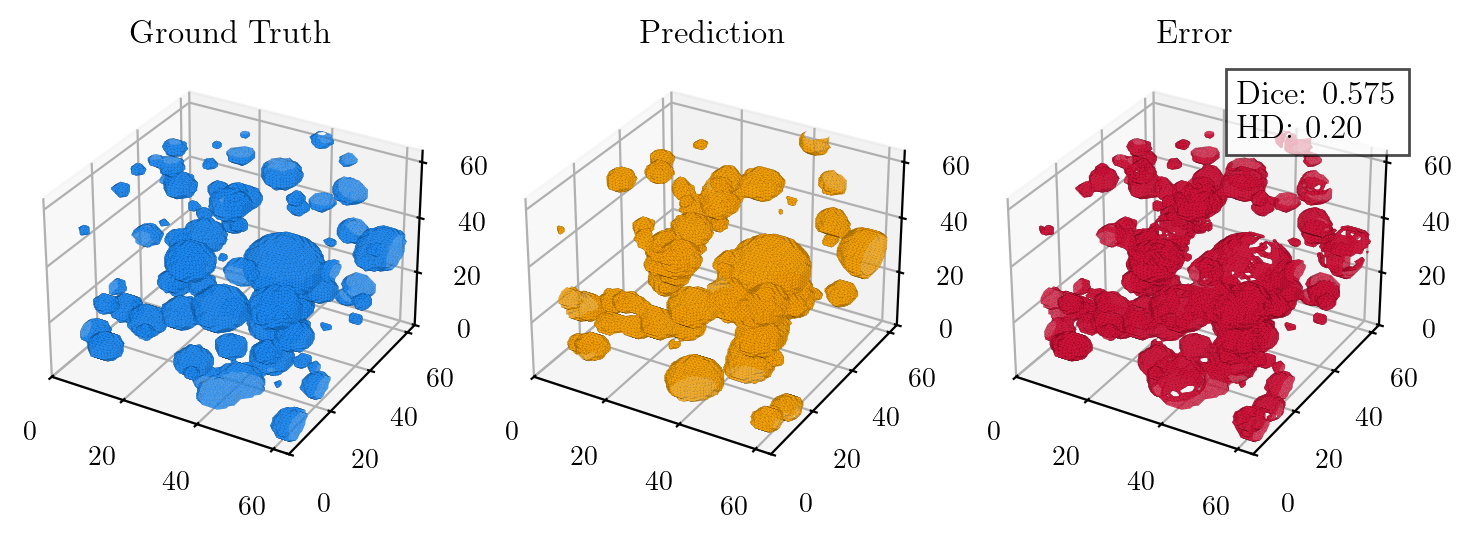

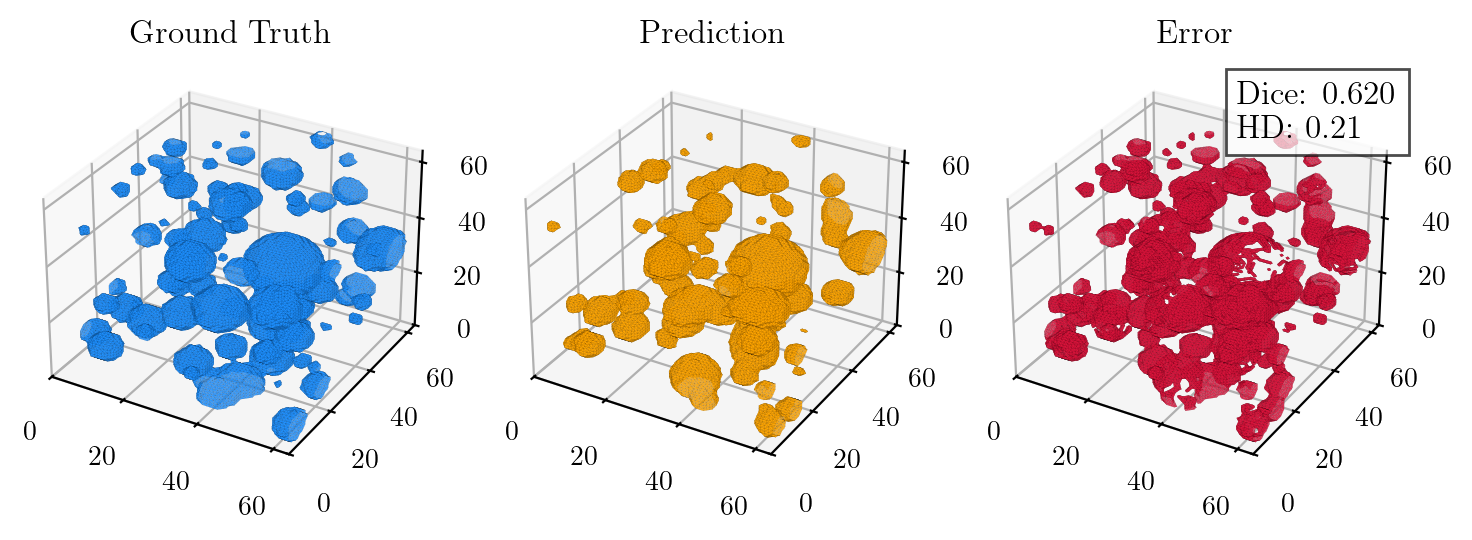

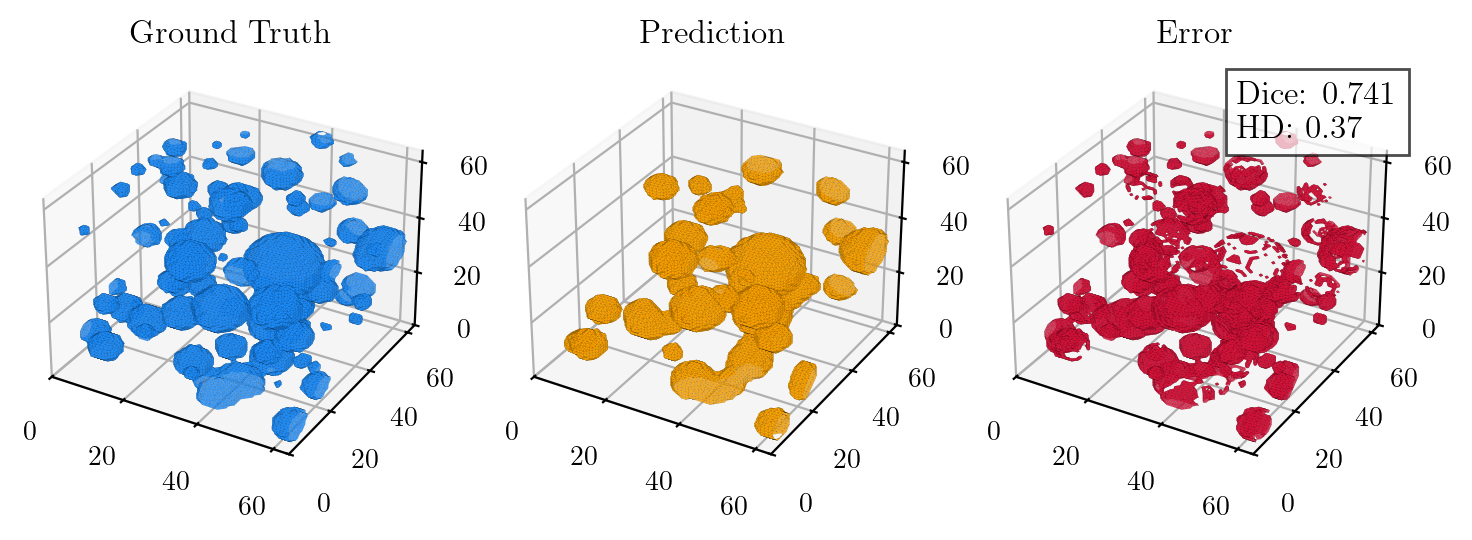

In [38]:
visualize_gt_pred(InterfaceType.TANH_EPSILON, 1.0, 1 / 8, 190, outpath='output/visualisation_1_8.pdf')
visualize_gt_pred(InterfaceType.TANH_EPSILON, 1.0, 1 / 32, 190, outpath='output/visualisation_1_32.pdf')
visualize_gt_pred(InterfaceType.TANH_EPSILON, 1.0, 1 / 128, 190, outpath='output/visualisation_1_128.pdf')

